In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.synonyms import toy_transformation
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.stats.h_testing import  LIMts_test
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.2964074471043285


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

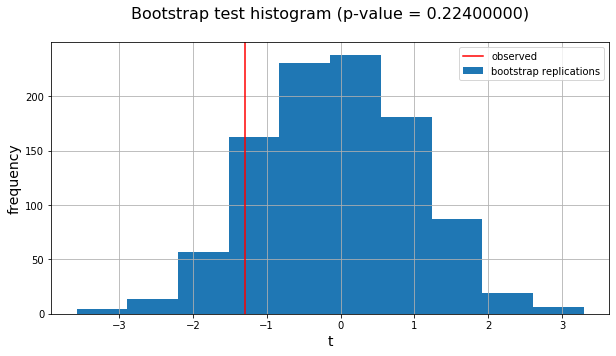

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [7]:
M,E,S = 5,1,1000


tests1 = LIMts_test(train=train,
                   dev=dev,
                   transformation=entailment_internalization,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=E,
                   S=S)

tests1

,experiment_index,observable_t_stats,p_value,boot_t_1,boot_t_2,boot_t_3,boot_t_4,boot_t_5,boot_t_6,boot_t_7,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,"(1, 1)",-8.164966,0.0,1.046351,0.746393,0.534905,-0.277403,-1.913524,-0.803075,-0.525588,...,0.555127,-1.239156,0.687614,-1.491465,0.000000,0.128042,-0.134846,1.124435,-0.420269,-0.468779
1,"(2, 1)",-8.273837,0.0,0.137367,0.000000,1.549526,0.000000,0.301580,-1.218053,0.294948,...,-0.412257,1.412558,-0.282899,-0.927810,-0.137367,-0.763109,0.404686,1.046351,0.282899,0.566139
2,"(3, 1)",-8.164966,0.0,-1.393466,0.134846,1.275153,0.577832,0.000000,1.240996,0.982559,...,0.308680,0.282899,0.701000,1.023727,-0.272216,0.000000,-0.272216,0.833494,0.603572,-0.412257
3,"(4, 1)",-8.164966,0.0,0.000000,0.566139,-0.746393,0.950825,-3.584247,-1.393466,-0.301580,...,0.577832,0.000000,-0.420269,0.428768,-0.651635,0.987128,-0.577832,0.132459,-0.950825,-0.687614
4,"(5, 1)",-8.164966,0.0,0.437805,0.142864,0.000000,0.534905,-1.439477,0.000000,0.294948,...,0.420269,-0.651635,-1.070544,0.763604,0.867654,0.447437,-1.196337,0.000000,-0.577832,0.258242


### Diferent bootstrap distributions for each experiment

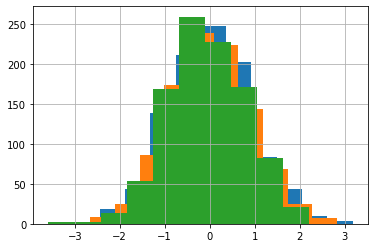

In [8]:
tests1.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

**test2: toy transformation**

In [9]:
tests2 = LIMts_test(train=train,
                   dev=dev,
                   transformation=toy_transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=E,
                   S=S)

tests2

,experiment_index,observable_t_stats,p_value,boot_t_1,boot_t_2,boot_t_3,boot_t_4,boot_t_5,boot_t_6,boot_t_7,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,"(1, 1)",0.906390,0.350,0.906390,0.000000,-1.393466,-0.301580,-0.277403,-0.471667,-1.613977,...,-0.775761,-0.906390,-1.393466,-0.833494,-0.333426,1.296407,0.000000,-1.270001,-2.340823,0.707992
1,"(2, 1)",0.333426,0.742,0.000000,-0.906390,-2.145596,-0.301580,0.000000,-1.072113,1.678363,...,-2.264554,1.270001,-1.158569,-0.707992,-1.347719,1.002509,1.072113,-0.378100,-0.378100,1.137556
2,"(3, 1)",0.000000,0.850,0.000000,0.301580,-1.002509,1.002509,-0.728572,-0.447437,0.000000,...,0.633089,-0.447437,0.277403,-0.333426,0.633089,-1.516196,-1.002509,-0.707992,0.447437,-0.906390
3,"(4, 1)",0.833494,0.418,-0.277403,-1.508509,0.000000,0.775761,-0.500313,0.000000,1.002509,...,-0.728572,-0.775761,-0.906390,-1.072113,1.072113,-0.301580,0.301580,-1.508509,2.571297,1.508509
4,"(5, 1)",0.000000,0.832,-1.393466,1.296407,1.745189,-0.333426,-0.500313,1.421338,-1.960008,...,1.296407,-1.393466,0.301580,-0.301580,0.534905,-0.577832,-1.150871,1.158569,-1.270001,-0.277403


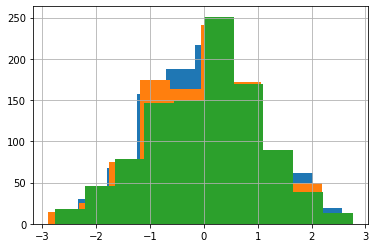

In [10]:
tests2.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

In [11]:
assert np.all(tests1.p_value < (0.05/M*E))
assert not np.all(tests2.p_value < (0.05/M*E))